# Regression Analysis

### Imports

In [10]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

C = 'consensus_time'
F = 'opinion_change_frequency'

FEATURES = [
    'clustering', 'closeness', 'betweenness',
    'average_shortest_path_lenght', 'eigenvector', 'assortativity',
    'information_centrality',
    'approximate_current_flow_betweenness_centrality', 'shannon_entropy',
    'degree_variance'
]

In [2]:
dataset = pd.read_csv('../data/dataset.csv')

### Creating Scaler

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# dataset[FEATURES] = scaler.fit_transform(dataset[FEATURES])
# dataset[['consensus_time', 'opinion_change_frequency']] = scaler.fit_transform(dataset[['consensus_time', 'opinion_change_frequency']])

### Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

# filtered_dataset.loc[:, FEATURES] = scaler.fit_transform(filtered_dataset[FEATURES])
# filtered_dataset.loc[:, 'opinion_change_frequency'] = scaler.fit_transform(np.array(filtered_dataset['opinion_change_frequency']).reshape(-1, 1))

SELECTED_FEATURES = ['clustering', 'approximate_current_flow_betweenness_centrality', 'shannon_entropy']


y = filtered_dataset['opinion_change_frequency']
X = sm.add_constant(
   filtered_dataset[FEATURES]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, shuffle=True
)

X_train[FEATURES] = scaler.fit_transform(X_train[FEATURES])
X_test[FEATURES] = scaler.transform(X_test[FEATURES])


## Linear

In [21]:
mod = sm.OLS(
    endog=y_train, 
    exog=X_train,
)
res = mod.fit()

In [28]:
y_pred = res.predict(X_test)

### Residuals

<Axes: xlabel='None', ylabel='None'>

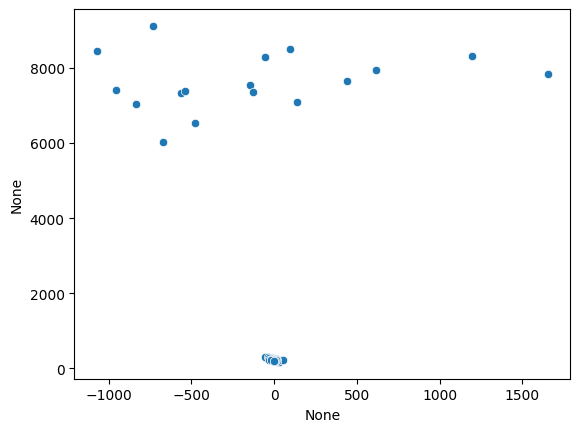

In [34]:
sns.scatterplot(x=y_test - y_pred, y=y_pred)

## Poisson

In [41]:
mod = sm.GLM(
    endog=y_train, 
    exog=X_train,
    family=sm.families.Poisson()
)
res = mod.fit()

In [42]:
print(res.summary())

                    Generalized Linear Model Regression Results                     
Dep. Variable:     opinion_change_frequency   No. Observations:                  446
Model:                                  GLM   Df Residuals:                      436
Model Family:                       Poisson   Df Model:                            9
Link Function:                          Log   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -4843.7
Date:                      Wed, 21 Aug 2024   Deviance:                       6180.0
Time:                              21:46:31   Pearson chi2:                 6.21e+03
No. Iterations:                           6   Pseudo R-squ. (CS):              1.000
Covariance Type:                  nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

In [43]:
y_pred = res.predict(X_test)

### Residual

<Axes: xlabel='None', ylabel='None'>

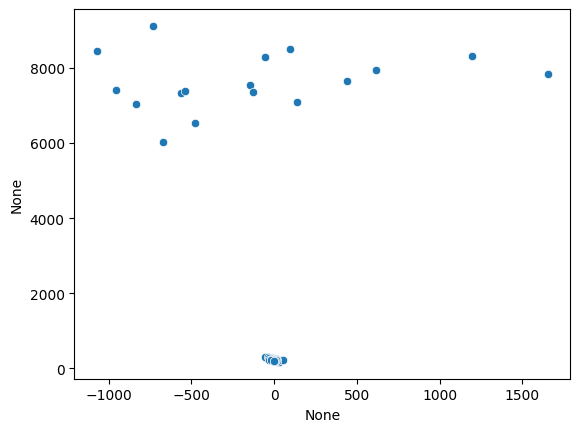

In [44]:
sns.scatterplot(x=y_test - y_pred, y=y_pred)

<Axes: ylabel='Count'>

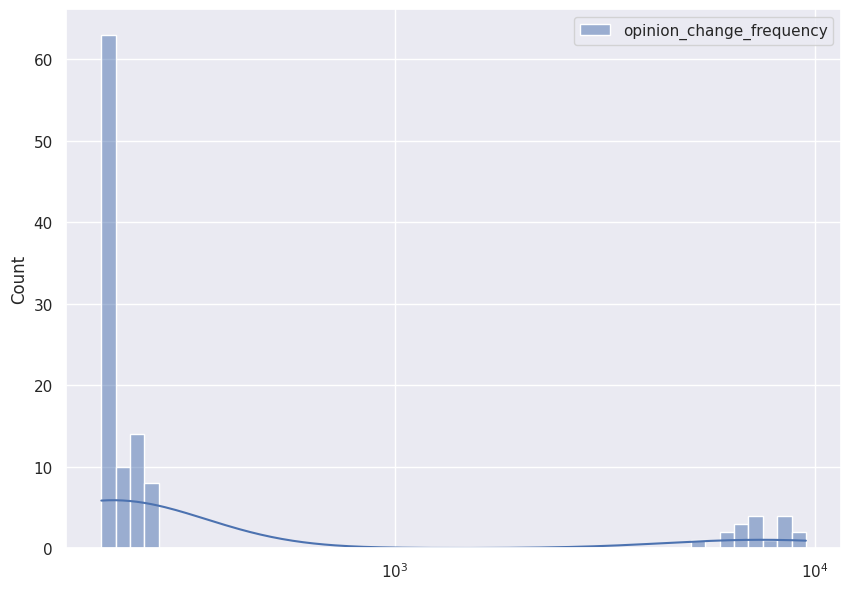

In [ ]:
sns.histplot([y_test_pred, y_test], kde=True, log_scale=(True, False), )

0.9883305805005373

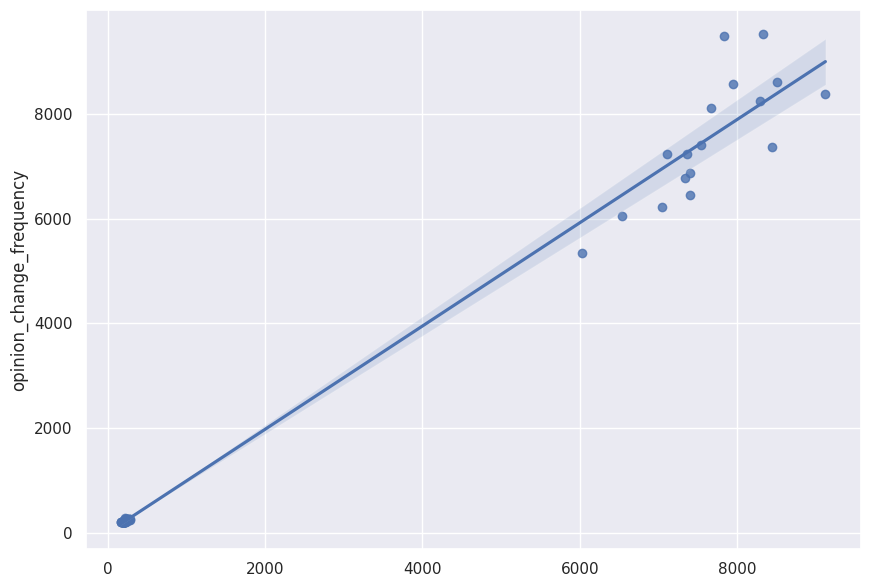

In [ ]:
sns.regplot(x=y_test_pred, y=y_test, data=None)

from sklearn.metrics import r2_score
r2_score(y_test_pred, y_test)